In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import urllib.request

# 从UCI上选择数据集对C4.5和CART算法生成的决策树进行实验比较。

## C4.5决策树

### 信息增益比

随机变量$X$的熵定义为
$$
H(X)=-\sum_{i=1}^{n} p_{i} \log p_{i}
$$

随机变量$X$给定的条件下随机变量$Y$的条件熵定义为
$$
H(Y|X)=\sum_{i=1}^{n}H(Y|X=x_{i})P(X=x_i)
$$



In [2]:
# 计算熵
def calEntroy(X):
    cnt = Counter(X)
    size = len(X)
    ent = 0
    for key, val in cnt.items():
        p = val/size
        ent += -p*np.log2(p) # 计算2为底的对数
    return ent

当熵和条件熵中的概率由数据估计(特别是极大似然估计)得到时，所对应的熵与条件熵分别称为经验熵（empirical entropy) 和经验条件精（empirical conditional entropy) 。
特征$A$对训练数据集$D$的信息增益定义为
$$
g(D, A)=H(D)-H(D|A)
$$



In [3]:
# 计算信息增益
def calInfoGain(X,Y):
    size = len(Y)
    H_D = calEntroy(Y) # 计算数据集的经验熵
    cnt = Counter(X) # 特征的分类统计
    H_DA = 0
    for key, val in cnt.items():
        D_i = Y[X==key] # 选出X=key的Y
        H_DA += val/size*calEntroy(D_i)
    return H_D - H_DA

特征$A$对$D$的划分为$\{D_1,D_2,…,D_n\}$，$\sum_{i=1}^n|D_i|=|D|$。
特征$A$对训练数据集$D$的分裂信息定义为
$$
H_{A}(D)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \log _{2} \frac{\left|D_{i}\right|}{|D|}
$$

特征$A$对训练数据集$D$的信息增益比定义为
$$
g_{R}(D, A)=\frac{g(D, A)}{H_{A}(D)}
$$

In [4]:
# 计算信息增益比
def calInfoGainRatio(X,Y):
    split_info = calEntroy(X) # 计算分裂信息
    info_gain = calInfoGain(X,Y) # 计算信息增益
    return info_gain/split_info

### C4.5的生成算法

输入:训练数据$D$，特征集A阈值$\epsilon$

输出:决策树$T$

(1) 如果$D$中所有实例属于同一类$C_k$，则置$T$为单结点树，并将$C_k$作为该结点的类，返回$T$；

(2) 如果$A=\varnothing$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；

(3) 否则，计算$A$中各特征对$D$的信息增益比，选择信息增益比最大的特征$A_g$；

(4) 如果$A_g$的信息增益比小于阔值$\epsilon$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；

(5) 否则，对$A_g$的每一可能值$\alpha_i$，依$A_g=\alpha_i$将$D$分割为子集若干非空$D_i$，将$D_i$中实例数最大的类作为标记，构建子结点，由结点及其子结点构成树$T$，返回$T$；

(6) 对结点$i$，以$D_i$为训练集，以$A-\{A_g\}$为特征集，递归地调用步(1)~步(5)，得到子树$T_i$，返回$T_i$。

In [5]:
# 决策树节点类
class TreeNode:
    def __init__(self, feather=None, alpha=None, category=None, sample=None, children=set()):
        self.feather = feather # 特征名
        self.alpha = alpha # 特征取值
        self.category = category # 分类
        self.sample = sample # 样本点
        self.children = children # 子节点

In [6]:
# 决策树基类
class DecisionTree:
    def __init__(self):
        self.root = TreeNode('F1', 'A1', 'C1',{TreeNode('F2', 'A2', 'C2'), TreeNode('F2', 'A3', 'C3')})

    # 展示决策树
    def display(self):
        def displayTree(node, depth):
            if node == None:
                return
            print('|'+(depth)*"   |"+'-'+str(depth)+'- '+str(node.feather)+' = '+str(node.alpha))
            print('|'+(depth+1)*"   |"+'==> '+'count: '+str(dict(Counter(node.sample)))+' ==> class: '+str(node.category))
            for child in node.children:
                displayTree(child, depth+1)

        print('Depth:',self.depth(), 'Leaves:',self.leaves())
        print('<BEGIN_OF_DESISION_TREE>')
        displayTree(self.root, 0)
        print('<END_OF_DESISION_TREE>')

    # 深度
    def depth(self):
        def depthTree(node):
            if not node:
                return 0
            elif not node.children:
                return 1
            else:
                depth_list = [depthTree(c) for c in node.children]
                return 1 + max(depth_list)
        return depthTree(self.root) - 1

    # 叶子节点数
    def leaves(self):
        def leavesTree(node):
            if not node:
                return 0
            elif not node.children:
                return 1
            else:
                leaves_list = [leavesTree(c) for c in node.children]
                return sum(leaves_list)
        return leavesTree(self.root)
        

In [7]:
# C4.5
class C45DecisionTree(DecisionTree):
    def __init__(self, threshold=0):
        self.threshold = threshold

    # 训练模型
    def fit(self, data, label):
        def fitTree(data, label):
            feath_list = data.columns # 特征名称
            cnt_label = Counter(label)
            # 1. 类别完全相同，直接返回
            if len(cnt_label) == 1:
                return set()
            # 2. 无特征，直接返回
            if len(feath_list) == 0:
                return set()
            # 3. 选择最优特征
            igr, best_feath = selBestFeather(data, label)
            # 4. 比较阈值
            if igr < self.threshold:
                return set()
            # 5. 递归构造
            children = set()
            cnt_feath = Counter(data[best_feath])
            for key, val in cnt_feath.items():
                new_data = data[data[best_feath]==key].drop(columns=best_feath)
                new_label = label[data[best_feath]==key]
                cnt_new_label = Counter(new_label)
                child_node = TreeNode(best_feath, key, cnt_new_label.most_common(1)[0][0], new_label)
                child_node.children = fitTree(new_data, new_label)
                children.add(child_node)
            return children

        # 选择最优特征
        def selBestFeather(data, label):
            feath_list = data.columns # 特征名称
            max_igr = -1
            best_i = 0
            for i in range(len(feath_list)):
                igr = calInfoGainRatio(data[feath_list[i]],label)
                if igr > max_igr:
                    max_igr = igr
                    best_i = i
            return max_igr, feath_list[best_i]

        cnt_label = Counter(label)
        self.root = TreeNode(category=cnt_label.most_common(1)[0][0], sample=label)
        self.root.children = fitTree(data, label)
        return self.root

    # 预测
    def predict(self, data):
        def predictTree(node, row):
            if not node.children:
                return node.category
            else:
                for child in node.children:
                    if list(row[child.feather])[0] == child.alpha:
                        return predictTree(child, row)
                return node.category

        pred = []
        for i in range(len(data)):
            pred.append(predictTree(self.root, data[i:i+1]))
        return pred

    # 评价准确率
    def evaluate(self, data, label):
        pred = self.predict(data)
        num_true = 0
        for p, l in zip(pred, label):
            if p == l:
                num_true += 1
        return num_true/len(label)

In [8]:
# Toy Example
df=pd.read_excel('example.xlsx').drop(columns=['ID'])
data=df[df.columns[:-1]]
label=df[df.columns[-1]]
# 建立决策树
toy_example = C45DecisionTree(0.076)
toy_example.fit(data, label)
toy_example.display()

Depth: 2 Leaves: 3
<BEGIN_OF_DESISION_TREE>
|-0- None = None
|   |==> count: {'否': 6, '是': 9} ==> class: 是
|   |-1- 有自己的房子 = 是
|   |   |==> count: {'是': 6} ==> class: 是
|   |-1- 有自己的房子 = 否
|   |   |==> count: {'否': 6, '是': 3} ==> class: 否
|   |   |-2- 有工作 = 否
|   |   |   |==> count: {'否': 6} ==> class: 否
|   |   |-2- 有工作 = 是
|   |   |   |==> count: {'是': 3} ==> class: 是
<END_OF_DESISION_TREE>


## CART决策树


### 基尼指数

分类问题中，假设有$K$个类，样本点属于第$k$类的概率为$p_{k}$，则概率分布的基尼指数定义为
$$
{\rm Gini}(p)=\sum_{k=1}^{K} p_{k}\left(1-p_{k}\right)=1-\sum_{k=1}^{K} p_{k}^{2}
$$

对于二类分类问题，若样本点属于第1个类的概率是$p$，则概率分布的基尼指数为

$$
{\rm Gini}(p)=2 p(1-p)
$$
对于给定的样本集合$D$，其基尼指数为
$$
{\rm Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}
$$
这里，$C_{k}$是$D$中属于第$k$类的样本子集，$K$是类的个数。

In [9]:
# 计算基尼指数
def calGini(X):
    cnt = Counter(X)
    size = len(X)
    gini = 1
    for key, val in cnt.items():
        p = val/size
        gini += -p**2
    return gini

如果样本集合$D$根据特征$A$是否取某一可能值$\alpha$被分割成$D_1$和$D_2$两部分，即

$$
D_{1}=\{(x, y) \in D \mid A(x)=a\}, \quad D_{2}=D-D_{1}
$$

则在特征$A$的条件下，集合$D$的基尼指数定义为

$$
\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)
$$

基尼指数${\rm Gini}(D)$表示集合$D$的不确定性，基尼指数${\rm Gini}(D,A)$表示经$A=\alpha$分割后集合$D$的不确定性。基尼指数值越大，样本集合的不确定性也就越大，这一点与熵相似。

### CART的生成算法

输入: 训练数据集$D$，停止计算的条件:

输出: CART决策树。

根据训练数据集，从根结点开始，递归地对每个结点进行以下操作，构建二叉决策树：

(1) 设结点的训练数据集为$D$，计算现有特征对该数据集的基尼指数。此时，对每一个特征$A$，对其可能取的每个值$\alpha$，根据样本点对$A=\alpha$的测试为“是”或“否”将$D$分割成$D_1$和$D_2$两部分，计算$A=\alpha$时的基尼指数。

(2) 在所有可能的特征$A$以及它们所有可能的切分点$\alpha$中，选择基尼指数最小的特征及其对应的切分点作为最优特征与最优切分点。依最优特征与最优切分点，从现结点生成两个子结点，将训练数据集依特征分配到两个子结点中去。

(3) 对两个子结点递归地调用(1)，(2)，直至满足停止条件。

(4) 生成CART决策树。

In [10]:
# CART
class CARTDecisionTree(DecisionTree):
    def __init__(self, threshold=0):
        self.threshold = threshold

    def fit(self, data, label):
        def fitTree(data, label):
            feath_list = data.columns # 特征名称
            cnt_label = Counter(label)
            # 0. 无特征，直接返回
            if len(feath_list) == 0:
                return set()
            # 0. 小于阈值，直接返回
            if calGini(label) < self.threshold:
                return set()
            # 1. 计算最优基尼指数
            GDA, best_feath, best_alpha = selBestFeather(data, label)
            #    best_feath下只有一类的话
            if len(data[data[best_feath]==best_alpha]) == len(data):
                return set()
            # 2. 递归构造
            # A==alpha
            new_data = data[data[best_feath]==best_alpha].drop(columns=best_feath)
            new_label = label[data[best_feath]==best_alpha]
            cnt_new_label = Counter(new_label)
            child_node_1 = TreeNode(best_feath, str(best_alpha), cnt_new_label.most_common(1)[0][0], new_label)
            child_node_1.children = fitTree(new_data, new_label)
            # A!=alpha
            new_data = data[data[best_feath]!=best_alpha].drop(columns=best_feath)
            new_label = label[data[best_feath]!=best_alpha]
            cnt_new_label = Counter(new_label)
            child_node_2 = TreeNode(best_feath, '!'+str(best_alpha), cnt_new_label.most_common(1)[0][0], new_label)
            child_node_2.children = fitTree(new_data, new_label)
            return {child_node_1, child_node_2}

        # 选择最优特征
        def selBestFeather(data, label):
            feath_list = data.columns # 特征名称
            min_GDA = 2
            best_feath = ''
            best_alpha = ''
            for feath in feath_list:
                cnt_feath = Counter(data[feath])
                size = len(data[feath])
                for key, val in cnt_feath.items():
                    GDA = val/size*calGini(label[data[feath]==key])+(size-val)/size*calGini(label[data[feath]!=key])
                    if GDA < min_GDA:
                        min_GDA = GDA
                        best_feath = feath
                        best_alpha = key
            return min_GDA, best_feath, best_alpha
    
        cnt_label = Counter(label)
        self.root = TreeNode(category=cnt_label.most_common(1)[0][0], sample=label)
        self.root.children = fitTree(data, label)
        return self.root

    # 预测
    def predict(self, data):
        def predictTree(node, row):
            if not node.children:
                return node.category
            else:
                children_list = list(node.children)
                positive = children_list[0] # 正类
                negative = children_list[1] # 负类
                if len(positive.alpha) > len(negative.alpha):
                    positive, negative = negative, positive
                if list(row[positive.feather])[0] == positive.alpha:
                    return predictTree(positive, row)
                else:
                    return predictTree(negative, row)

        pred = []
        for i in range(len(data)):
            pred.append(predictTree(self.root, data[i:i+1]))
        return pred

    # 评价准确率
    def evaluate(self, data, label):
        pred = self.predict(data)
        num_true = 0
        for p, l in zip(pred, label):
            if p == l:
                num_true += 1
        return num_true/len(label)

In [11]:
# Toy Example
df=pd.read_excel('example.xlsx').drop(columns=['ID'])
data=df[df.columns[:-1]]
label=df[df.columns[-1]]
# 建立决策树
toy_example = CARTDecisionTree(0.1)
toy_example.fit(data, label)
toy_example.display()

Depth: 2 Leaves: 3
<BEGIN_OF_DESISION_TREE>
|-0- None = None
|   |==> count: {'否': 6, '是': 9} ==> class: 是
|   |-1- 有自己的房子 = 否
|   |   |==> count: {'否': 6, '是': 3} ==> class: 否
|   |   |-2- 有工作 = 否
|   |   |   |==> count: {'否': 6} ==> class: 否
|   |   |-2- 有工作 = !否
|   |   |   |==> count: {'是': 3} ==> class: 是
|   |-1- 有自己的房子 = !否
|   |   |==> count: {'是': 6} ==> class: 是
<END_OF_DESISION_TREE>


## 算法对比

从UCI上选择五个数据集，分别为nursery、mushroom、chess、tic-tac-toe、voting-records，均为离散特征的分类问题。

In [12]:
# 读取UCI数据
def loadDataset(fname, label_first=True, is_plot=False):
    url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/'+fname
    raw_data = urllib.request.urlopen(url)
    df = pd.read_csv(raw_data, header=None)
    df = df.replace('?', np.nan)
    df = df.dropna(axis=0, how='any')
    df = df.reset_index(drop=True)
    if label_first:
        data = df[df.columns[1:]]
        label = df[df.columns[0]]
    else:
        data = df[df.columns[0:-1]]
        label = df[df.columns[-1]]

    if is_plot:
        plt.hist(label)
        plt.title(fname)
    return data, label

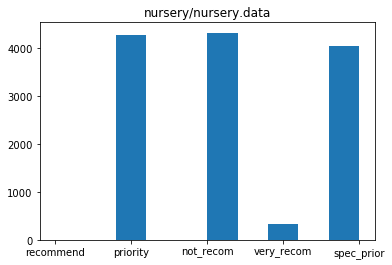

In [13]:
data, label = loadDataset('nursery/nursery.data', False, is_plot=True)

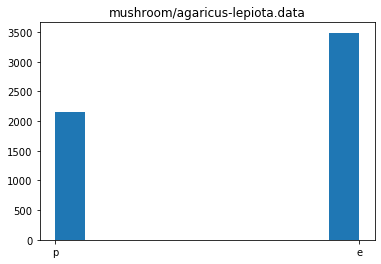

In [14]:
data, label = loadDataset('mushroom/agaricus-lepiota.data', is_plot=True)

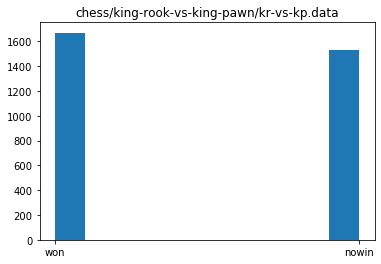

In [15]:
data, label = loadDataset('chess/king-rook-vs-king-pawn/kr-vs-kp.data', False, is_plot=True)

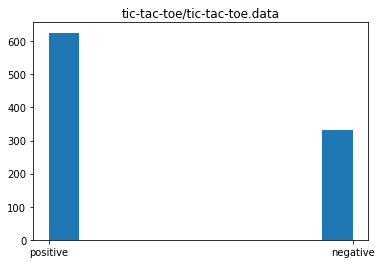

In [16]:
data, label = loadDataset('tic-tac-toe/tic-tac-toe.data', False, is_plot=True)

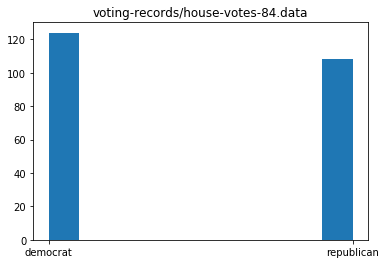

In [17]:
data, label = loadDataset('voting-records/house-votes-84.data', is_plot=True)

将数据集按照3:1划分为训练集和测试集，分别使用C4.5和CART决策树在一系列阈值下进行训练和预测，选取测试集准确率最高的模型，进行深度、叶子数、准确率等对比。

In [18]:
# 对阈值遍历
def selThreshold(DecisionTreeModel, lb=0, ub=1, step=0.1):
    metrics = {'Threshold':[], 'Depth':[], 'Leaves':[], 'Acc_train':[], 'Acc_test':[]}
    for threshold in np.arange(lb, ub, step):
        tree = DecisionTreeModel(threshold)
        tree.fit(data_train, label_train)

        metrics['Threshold'].append(threshold)
        metrics['Depth'].append(tree.depth())
        metrics['Leaves'].append(tree.leaves())
        metrics['Acc_train'].append(tree.evaluate(data_train, label_train))
        metrics['Acc_test'].append(tree.evaluate(data_test, label_test))

    return metrics

In [19]:
fname_list = ['nursery/nursery.data','mushroom/agaricus-lepiota.data','chess/king-rook-vs-king-pawn/kr-vs-kp.data','tic-tac-toe/tic-tac-toe.data','voting-records/house-votes-84.data']
label_first_list = [False, True, False, False, True]
comp = pd.DataFrame({'Dataset':[], 'Tree_type':[], 'Threshold':[], 'Depth':[], 'Leaves':[], 'Acc_train':[], 'Acc_test':[]})
for i in range(5):
    data, label = loadDataset(fname_list[i], label_first_list[i])
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.25, random_state=2020, stratify=label)# 数据集划分
    C45_metics = selThreshold(C45DecisionTree)
    C45_best = pd.DataFrame(C45_metics).iloc[np.argmax(C45_metics['Acc_test'])]
    C45_best['Dataset'] = fname_list[i][:3]
    C45_best['Tree_type'] = 'C4.5'
    comp = comp.append(C45_best)
    CART_metics = selThreshold(CARTDecisionTree)
    CART_best = pd.DataFrame(CART_metics).iloc[np.argmax(CART_metics['Acc_test'])]
    CART_best['Dataset'] = fname_list[i][:3]
    CART_best['Tree_type'] = 'CART'
    comp = comp.append(CART_best)

comp = comp.reset_index(drop=True)

In [20]:
comp

,Dataset,Tree_type,Threshold,Depth,Leaves,Acc_train,Acc_test
0,nur,C4.5,0.0,8.0,740.0,1.000000,0.980556
1,nur,CART,0.3,8.0,49.0,0.834568,0.833951
2,mus,C4.5,0.0,5.0,12.0,1.000000,1.000000
3,mus,CART,0.0,10.0,68.0,1.000000,1.000000
4,che,C4.5,0.0,16.0,47.0,1.000000,0.993742
5,che,CART,0.0,19.0,174.0,1.000000,0.994994
6,tic,C4.5,0.0,7.0,141.0,1.000000,0.858333
7,tic,CART,0.0,9.0,353.0,1.000000,0.979167
8,vot,C4.5,0.3,1.0,2.0,0.971264,0.965517
9,vot,CART,0.2,1.0,2.0,0.971264,0.965517


从以上表格可以看到，两种算法在不同数据集上表现存在差异。对于大部分数据集，当阈值越低，决策树深度越深，叶子结点越多时，测试集准确率达到最高。也就是说，对于这些数据集，过拟合现象并不明显。

由于C4.5决策树为多叉树，而CART决策树为二叉树，因此C4.5算法可能在深度较小时便完成了数据的学习，而CART算法则需要更多的深度来对数据进行学习。但在深度相同时，C4.5算法往往比CART算法叶子结点更多。

# 对C4.5算法设计一种新剪枝算法，并从UCI上选择数据集对型算法和已有算法进行实验比较。

## 已有剪枝算法

### 决策树的损失函数
决策树的剪枝往往通过极小化决策树整体的损失函数（loss function）或代价函数（cost function）来实现。设树$T$的叶结点个数为$|T|$，$t$是树$T$的叶结点，该叶结点有$N_{t}$个样本点，其中$k$类的样本点有$N_{t k}$个, $k=1,2, \cdots, K$，$H_{t}(T)$为叶结点$t$上的经验熵，$\alpha \geqslant 0$为参数，则决策树学习的损失函数可以定义为
$$
C_{\alpha}(T)=\sum_{t=1}^{|T|} N_{t} H_{t}(T)+\alpha|T|
$$

其中经验熵为
$$
H_{t}(T)=-\sum_{k} \frac{N_{t k}}{N_{t}} \log \frac{N_{t k}}{N_{t}}
$$

在损失函数中，上式右端的第1项记作
$$
C(T)=\sum_{t=1}^{|T|} N_{t} H_{t}(T)=-\sum_{t=1}^{|T|} \sum_{k=1}^{K} N_{t k} \log \frac{N_{t k}}{N_{t}}
$$

这时有
$$
C_{\alpha}(T)=C(T)+\alpha|T|
$$

其中$C(T)$表示模型对训练数据的预测误差，即模型与训练数据的拟合程度，$|T|$表示模型复杂度，参数$\alpha \geqslant 0$控制两者之间的影响。较大的$\alpha$促使选择较简单的模型（树），较小的$\alpha$促使选择较复杂的模型（树）。$\alpha=0$意味着只考虑模型与训练数据的拟合程度，不考虑模型的复杂度。


In [21]:
def loss(self, alpha):
    def lossFunc(node):
        if not node.children:
            return len(node.sample)*calEntroy(node.sample) + alpha
        else:
            loss_list = [lossFunc(c) for c in node.children]
            return sum(loss_list)

    return lossFunc(self.root)

C45DecisionTree.loss = loss

### 树的剪枝算法

输入:生成算法产生的整个树$T$，参数$\alpha$;

输出:修剪后的子树$T_\alpha$。

(1) 计算每个结点的经验熵。

(2) 递归地从树的叶结点向上回缩。

设一组叶结点回缩到其父结点之前与之后的整体树分别为$T_B$与$T_A$，其对应的损失函数值分别是$C_\alpha(T_B)$与$C_\alpha(T_A)$，如果
$$
C_{\alpha}\left(T_{A}\right) \leqslant C_{\alpha}\left(T_{B}\right)
$$

则进行剪枝，即将父结点变为新的叶结点。

(3) 返回(2)，直至不能继续为止，得到损失函数最小的子树$T_\alpha$。

In [22]:
def prune(self, alpha):
    def pruneTree(node):
        if not node.children:
            return True # 是叶子结点
        
        leaf_list = [pruneTree(c) for c in node.children]
        if all(leaf_list): # 下面都是叶子节点
            origin_loss = self.loss(alpha) # 原始损失
            backup = node.children # 备份
            node.children = set() # 剪去子树
            pruned_loss = self.loss(alpha) # 剪后损失
            if origin_loss < pruned_loss:
                node.children = backup # 复原
            else:
                return True # 现在是叶子结点了
        return False
    
    pruneTree(self.root)

C45DecisionTree.prune = prune

In [23]:
data, label = loadDataset('chess/king-rook-vs-king-pawn/kr-vs-kp.data', False)
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.25, random_state=2020, stratify=label)# 数据集划分

In [24]:
C45_tree = C45DecisionTree(0.0)
C45_tree.fit(data_train, label_train)
print('Before pruning —— Depth:', C45_tree.depth(),'Leaves:', C45_tree.leaves(), '\n')
print(classification_report(label_test, C45_tree.predict(data_test), digits=6))

Before pruning —— Depth: 16 Leaves: 47 

              precision    recall  f1-score   support

       nowin   0.987080  1.000000  0.993498       382
         won   1.000000  0.988010  0.993969       417

    accuracy                       0.993742       799
   macro avg   0.993540  0.994005  0.993733       799
weighted avg   0.993823  0.993742  0.993744       799



In [25]:
C45_tree.prune(10)
print('After pruning —— Depth:', C45_tree.depth(),'Leaves:', C45_tree.leaves(), '\n')
print(classification_report(label_test, C45_tree.predict(data_test), digits=6))

After pruning —— Depth: 12 Leaves: 26 

              precision    recall  f1-score   support

       nowin   0.986945  0.989529  0.988235       382
         won   0.990385  0.988010  0.989196       417

    accuracy                       0.988736       799
   macro avg   0.988665  0.988769  0.988715       799
weighted avg   0.988740  0.988736  0.988737       799



## 设计新的剪枝算法

从训练集中再划分出一个验证集，用验证集对决策树进行剪枝，如果剪枝后决策树的准确率降低，则拒绝该次剪枝，如果准确率提高了，则接受该次剪枝。

In [26]:
def newprune(self, data_val, label_val):
    def pruneTree(node):
        if not node.children:
            return True # 是叶子结点
        
        leaf_list = [pruneTree(c) for c in node.children]
        if all(leaf_list): # 下面都是叶子节点
            origin_acc = self.evaluate(data_val, label_val) # 原始准确率
            backup = node.children # 备份
            node.children = set() # 剪去子树
            pruned_acc = self.evaluate(data_val, label_val) # 剪后准确率
            if origin_acc > pruned_acc:
                node.children = backup # 复原
            else:
                return True # 现在是叶子结点了
        return False
    
    pruneTree(self.root)

C45DecisionTree.newprune = newprune

In [27]:
data, label = loadDataset('chess/king-rook-vs-king-pawn/kr-vs-kp.data', False)
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.25, random_state=2020, stratify=label)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=0.25, random_state=2020, stratify=label_train)

C45_tree = C45DecisionTree(0.0)
C45_tree.fit(data_train, label_train)
C45_tree.newprune(data_val, label_val)
print('After pruning —— Depth:', C45_tree.depth(),'Leaves:', C45_tree.leaves(), '\n')
print(classification_report(label_test, C45_tree.predict(data_test), digits=6))

After pruning —— Depth: 13 Leaves: 28 

              precision    recall  f1-score   support

       nowin   0.994764  0.994764  0.994764       382
         won   0.995204  0.995204  0.995204       417

    accuracy                       0.994994       799
   macro avg   0.994984  0.994984  0.994984       799
weighted avg   0.994994  0.994994  0.994994       799



比较以上两种剪枝算法，两者均将决策树深度和叶子数降低了许多，使得模型复杂度降低了不少，从而降低了泛化误差，并且准确率仍保持在0.99左右。说明以上两种剪枝算法均有效。

此外，新设计的剪枝算法虽然简单，但在测试集上的准确率反而高于未剪枝和已有的剪枝算法，说明新设计的剪枝算法是十分有效的。